In [2]:
import numpy as np
import uproot
import uproot_methods
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from iminuit import Minuit
import utils
import cPickle as pickle

print "MPL:",mpl.__version__

MPL: 1.5.2


## Load data from ROOT trees

The function utils.LoadData uses `uproot` to convert ROOT trees into pandas dataframes, while pruning unnecessary columns and applying a preselection.
* **Data**: checks triggers and golden JSON, and throws away failing events
* **Signal**: checks decay mode, and picks only phi/rho events based on the above flag
* **All**: Checks MET filters, assigns mcand mass based on pis/Ks, picks the best mcand in each event,
cuts on mcand mass, adds lepton_photon mass column, cuts out lep_pho Z-peak, cuts on mcand/photon dR (to remove degenerate cases where they are the same object)

The dataframes are stored in pickled files to avoid having to do this costly preprocessing every time


In [3]:
DOPHI = True
mname = "phi" if DOPHI else "rho"

# dfs = utils.LoadData("/nfs-7/userdata/bemarsh/rare-higgs/btree/v1/", years=[2016,2017,2018], do_phi=DOPHI, do_blind=False)
# pickle.dump(dfs, open("dataframes_{0}_v1.pkl".format(mname), 'wb'))

# load from a previously stored pickle
dfs = pickle.load(open("dataframes_{0}_v1.pkl".format(mname), 'rb'))

print "Loaded data"

Loading from file /nfs-7/userdata/bemarsh/rare-higgs/btree/v1/2016/ttjets_incl.root
Loading from file /nfs-7/userdata/bemarsh/rare-higgs/btree/v1/2016/ttsl_tbar_ext1.root


/home/users/bemarsh/.local/lib/python2.7/site-packages/uproot_methods/classes/TLorentzVector.py:181: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))


Loading from file /nfs-7/userdata/bemarsh/rare-higgs/btree/v1/2016/wg_ext1.root
Loading from file /nfs-7/userdata/bemarsh/rare-higgs/btree/v1/2016/data_Run2016F_SingleElectron_17Jul2018-v1.root
Loading from file /nfs-7/userdata/bemarsh/rare-higgs/btree/v1/2016/tt_powheg.root
Loading from file /nfs-7/userdata/bemarsh/rare-higgs/btree/v1/2016/wjets.root
Loading from file /nfs-7/userdata/bemarsh/rare-higgs/btree/v1/2016/data_Run2016C_SingleMuon_17Jul2018-v1.root
Loading from file /nfs-7/userdata/bemarsh/rare-higgs/btree/v1/2016/data_Run2016H_SingleElectron_17Jul2018-v1.root
Loading from file /nfs-7/userdata/bemarsh/rare-higgs/btree/v1/2016/data_Run2016E_SingleMuon_17Jul2018-v1.root
Loading from file /nfs-7/userdata/bemarsh/rare-higgs/btree/v1/2016/data_Run2016D_SingleElectron_17Jul2018-v1.root
Loading from file /nfs-7/userdata/bemarsh/rare-higgs/btree/v1/2016/wg_ext3.root
Loading from file /nfs-7/userdata/bemarsh/rare-higgs/btree/v1/2016/ttgamma_tbar.root
Loading from file /nfs-7/userdata

In [4]:
# group into categories: data, background (MC), and signal (MC)
dfs_data, dfs_bkg, dfs_sig = [], [], []
for y in dfs:
    for s in dfs[y]:
        dfs[y][s]["samp"] = s
        if s.startswith("data"):
            dfs_data.append(dfs[y][s])
        elif s.startswith("wh"):
            dfs_sig.append(dfs[y][s])
        else:
            dfs_bkg.append(dfs[y][s])

print "Number of samples (data,bkg,sig):",len(dfs_data),len(dfs_bkg),len(dfs_sig)

Number of samples (data,bkg,sig): 32 49 1


In [5]:
# concatenate everything in like categories
df_data = pd.concat(dfs_data, ignore_index=True)
df_bkg = pd.concat(dfs_bkg, ignore_index=True)
df_sig = pd.concat(dfs_sig, ignore_index=True)
print "df shape (data,bkg,sig):",df_data.shape, df_bkg.shape, df_sig.shape

for df,name in zip([df_bkg, df_sig, df_data],["Background","Signal","Data"]):
    # few random events have random NaN angles (?) Only few out of thousands, so ignore
    print name
    bad_idxs = df.isnull().any(axis=1)
    print "  # rows with NaN:", np.sum(bad_idxs)
    print "  Columns with NaN:", df.columns[df.isnull().any(axis=0)].values.tolist()
    todrop = df[bad_idxs].index
    df.drop(todrop, inplace=True)

df shape (data,bkg,sig): (1905, 51) (12287, 51) (30824, 83)
Background
  # rows with NaN: 2
  Columns with NaN: [u'vhAngles_cosThetaStar', u'vhAngles_cosTheta1', u'vhAngles_cosTheta2', u'vhAngles_phi', u'vhAngles_phi1', u'vhAngles_m1', u'vhAngles_m2']
Signal
  # rows with NaN: 0
  Columns with NaN: []
Data
  # rows with NaN: 0
  Columns with NaN: []


## Prepare for BDT training
* Add a "signal" column as the target variable
* Select only the columns we want as features in the BDT
* Additionally scale the mcand and photon pTs by the mcand_photon invariant mass. This removes correlations between the pT's and the mass, so that the BDT doesn't learn the Higgs mass and sculpt the background

In [6]:
# form arrays for training

def get_bdt_input(df, bdt_features):
    # select the features used for training
    
    X = df.copy()
    
    X.photon_isTightCutBased = X.photon_isTightCutBased.astype(int)

    # scale photon/mcand pT by KKgamma/PiPiGamma mass, to reduce correlations (don't want to sculpt mass distribution)
    to_divide = ["photon_pt","mcand_pt"]
    for f in to_divide:
        X[f] /= X.mcand_photon_mass
        
    X = X[bdt_features]

    return X


df_bkg["signal"] = 0
df_sig["signal"] = 1

X = pd.concat([df_bkg,df_sig], ignore_index=True, sort=False)
y = X.signal
higgs_mass = X.mcand_photon_mass
samps = X.sample

bdt_features = ["photon_pt","photon_eta","photon_phi","photon_isTightCutBased","photon_relChHadIso",
                "mcand_mass","mcand_pt","mcand_eta","mcand_phi","mcand_dR","mcand_relIso","mcand_photon_dR",
                "lepton_pt","lepton_eta","lepton_phi","lepton_miniRelIso", "lepton_photon_dR",
                "met_pt","met_phi", "vhAngles_cosThetaStar","vhAngles_cosTheta1","vhAngles_cosTheta2",
                "vhAngles_phi", "vhAngles_phi1"]

X = get_bdt_input(X, bdt_features)

# convert booleans to ints

print "Number of BDT features", len(bdt_features)
print "X shape:", X.shape
X.head(10)

Number of BDT features 24
X shape: (43109, 24)


,photon_pt,photon_eta,photon_phi,photon_isTightCutBased,photon_relChHadIso,mcand_mass,mcand_pt,mcand_eta,mcand_phi,mcand_dR,...,lepton_phi,lepton_miniRelIso,lepton_photon_dR,met_pt,met_phi,vhAngles_cosThetaStar,vhAngles_cosTheta1,vhAngles_cosTheta2,vhAngles_phi,vhAngles_phi1
0,0.610879,0.692729,1.165463,1,0.005535,1.022214,0.292007,2.193770,-0.870201,0.015074,...,1.531409,0.000000,0.815211,21.617439,-2.804520,-0.191660,0.525420,-0.125465,2.441461,-1.980772
1,0.988091,-0.619301,1.718493,1,0.000000,1.025039,0.526075,0.430915,2.591784,0.017545,...,-0.806413,0.000000,3.229620,117.176964,-2.136612,0.663572,-0.794528,-0.404491,1.486233,2.290753
2,0.415908,-0.783950,1.298188,1,0.000000,1.024123,0.389549,-2.189666,-1.451343,0.022784,...,1.391904,0.000000,0.764814,79.850655,-1.378089,-0.403087,-0.921939,-0.851061,2.844857,0.400577
3,0.932214,1.027487,-2.987675,1,0.000000,1.006479,0.502496,0.668038,-1.414965,0.015298,...,0.091072,0.000000,3.168511,55.207703,-0.770874,0.670439,0.370189,0.244267,2.351955,1.898817
4,0.508137,-2.489484,-2.829956,1,0.000000,1.015385,0.450036,-1.390879,-0.712869,0.011708,...,2.368510,0.037721,2.605418,47.305428,-2.469477,0.364380,-0.796514,0.235103,-1.206990,-3.092380
5,1.719935,-1.136770,-2.683027,1,0.017006,1.014723,2.145436,-0.652680,-2.861874,0.009098,...,1.702002,0.000000,1.907609,97.187401,-2.498169,-0.042689,-0.675385,0.724710,0.604787,-2.626770
6,0.656842,-2.432373,0.839426,1,0.000000,1.000000,0.525141,-2.104972,2.816642,0.007548,...,1.162374,0.000000,0.334224,94.215248,-0.968211,-0.090433,-0.147311,-0.928107,1.278192,2.118170
7,0.514128,-0.202332,-0.031780,1,0.000000,1.001220,0.461337,-0.919447,2.535538,0.012689,...,-0.365308,0.000000,0.340726,55.961330,0.779096,-0.727915,-0.836909,-0.430013,-0.766611,-2.859488
8,0.944654,-1.328305,0.096026,1,0.000000,1.008993,0.116009,1.072565,0.134124,0.014884,...,1.195371,0.000000,2.104329,91.575211,1.142326,0.884882,-0.712704,-0.447250,-0.117060,3.039905
9,0.481072,0.009242,-0.184190,1,0.000000,1.026266,0.446669,0.939564,-2.794146,0.007152,...,2.145103,0.000000,2.367680,61.630165,2.266878,0.387887,-0.085058,-0.131065,-0.053965,-2.123548


## Signal/background comparison plots
To get a feel for what we're working with, make comparison histograms between signal/background for all of the input training features.

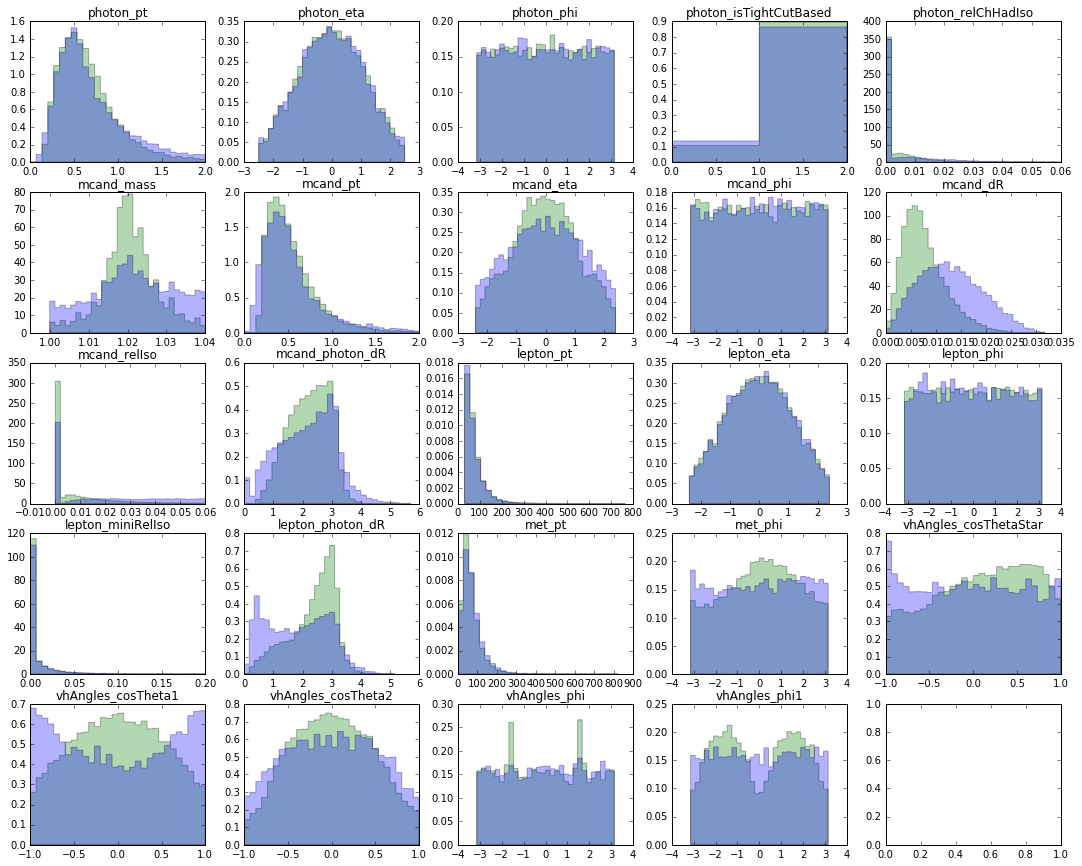

In [7]:
# make bkg/signal histograms of all BDT inputs

plt.close("all")
fig,axs = plt.subplots(5,5,figsize=(15,12))
fig.tight_layout()
axs = axs.flatten()
custom_bins = {
    "photon_pt": np.linspace(0,2,31),
    "photon_isTightCutBased": np.linspace(0,2,3),
    "mcand_pt": np.linspace(0,2,31),
    "lepton_photon_mass": np.linspace(0,200,41)
}
for i,f in enumerate(bdt_features):
    ax = axs[i]
    vals_bkg = X[y == 0][f]
    vals_sig = X[y == 1][f]
    bins = custom_bins[f] if f in custom_bins else 30
    ax.hist([vals_bkg,vals_sig], bins=bins, histtype="stepfilled", stacked=False, alpha=0.3, normed=True)
    ax.set_title(f)

### Construct and train the BDT
* Split into training and test datasets
* Create an `XGBClassifier` with a binary logistic training objective.
* Train until we stop seeing gains in performance
* Parameters used here are from a brief hyperparameter optimization study

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

print X_train.shape, X_test.shape, y_train.shape, y_test.shape
print sum(y_train), sum(y_test)

(32331, 24) (10778, 24) (32331,) (10778,)
23199 7625


In [9]:
import xgboost as xgb

bdt = xgb.XGBClassifier(
    objective = 'binary:logistic',
    n_estimators = 500,
    learning_rate = 0.1,
    max_depth = 3,
    verbosity = 1,
    nthread = 12,
    subsample = 0.6,
    gamma = 2.0,
    reg_alpha = 8.0,
    reg_lambda = 1.0,
    min_child_weight = 5.0,
    colsample_bytree = 1.0,
    scale_pos_weight = 1.0*sum(y_train == 0) / sum(y_train == 1),  # balance signal and background
    random_state = 1,
)

print bdt.scale_pos_weight

0.393637656796


In [10]:
# # do a hyperparameter grid search

# from sklearn.model_selection import GridSearchCV

# params = {
#     "max_depth" : [3,4],
#     "learning_rate" : [0.1,0.2],
#     #"n_estimators" : [100,200,500],
#     "gamma" : [0.5,1.0,2.0]
# }

# search = GridSearchCV(bdt, param_grid=params, cv=3, verbose=1, n_jobs=1, scoring='roc_auc')

# search.fit(X_train, y_train)

In [11]:
# print search.best_params_
# print search.best_score_

In [12]:
eval_set = [(X_train,y_train),(X_test,y_test)]
bdt.fit(X_train, y_train, eval_set=eval_set, eval_metric='auc', early_stopping_rounds=5)

# preds_train = bdt.predict_proba(X_train)[:,1]
# preds_test = bdt.predict_proba(X_test)[:,1]

preds_train = bdt.get_booster().predict(xgb.DMatrix(X_train))
preds_test = bdt.get_booster().predict(xgb.DMatrix(X_test))

[0]	validation_0-auc:0.838137	validation_1-auc:0.840599
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.855399	validation_1-auc:0.85524
[2]	validation_0-auc:0.858874	validation_1-auc:0.859503
[3]	validation_0-auc:0.867905	validation_1-auc:0.868643
[4]	validation_0-auc:0.877991	validation_1-auc:0.880797
[5]	validation_0-auc:0.884127	validation_1-auc:0.885812
[6]	validation_0-auc:0.886548	validation_1-auc:0.888609
[7]	validation_0-auc:0.889096	validation_1-auc:0.891315
[8]	validation_0-auc:0.894249	validation_1-auc:0.896188
[9]	validation_0-auc:0.894819	validation_1-auc:0.897138
[10]	validation_0-auc:0.896341	validation_1-auc:0.898173
[11]	validation_0-auc:0.900982	validation_1-auc:0.901917
[12]	validation_0-auc:0.904515	validation_1-auc:0.905859
[13]	validation_0-auc:0.905391	validation_1-auc:0.906613
[14]	validation_0-auc:0.906562	validation_1-auc:0.907893


[141]	validation_0-auc:0.964245	validation_1-auc:0.958114
[142]	validation_0-auc:0.964301	validation_1-auc:0.958158
[143]	validation_0-auc:0.964393	validation_1-auc:0.958203
[144]	validation_0-auc:0.964495	validation_1-auc:0.958307
[145]	validation_0-auc:0.964588	validation_1-auc:0.958417
[146]	validation_0-auc:0.964773	validation_1-auc:0.958616
[147]	validation_0-auc:0.964803	validation_1-auc:0.958647
[148]	validation_0-auc:0.964911	validation_1-auc:0.958777
[149]	validation_0-auc:0.964917	validation_1-auc:0.958744
[150]	validation_0-auc:0.965001	validation_1-auc:0.95879
[151]	validation_0-auc:0.965024	validation_1-auc:0.958793
[152]	validation_0-auc:0.9651	validation_1-auc:0.9589
[153]	validation_0-auc:0.965205	validation_1-auc:0.958944
[154]	validation_0-auc:0.965275	validation_1-auc:0.958924
[155]	validation_0-auc:0.96535	validation_1-auc:0.958938
[156]	validation_0-auc:0.965351	validation_1-auc:0.958928
[157]	validation_0-auc:0.965416	validation_1-auc:0.958997
[158]	validation_0-a

## Evaluate performance
Plot ROC curves and BDT score histograms for the training and testing sets. We see that there is a small amount of over-training, but this won't affect accuracy of final results.

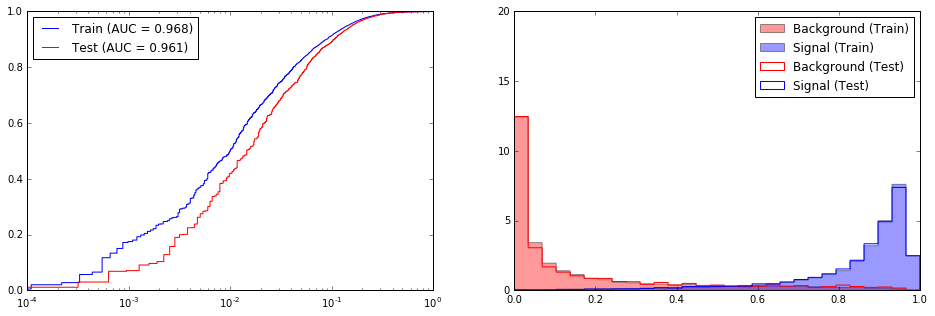

In [13]:
from sklearn.metrics import roc_curve

fix, axs = plt.subplots(1,2,figsize=(16,5))

plt.subplot(1,2,1)
fpr_train, tpr_train, thresh_train = roc_curve(y_train, preds_train)
fpr_test, tpr_test, thresh_test = roc_curve(y_test, preds_test)
auc_train = np.trapz(tpr_train, fpr_train)
auc_test = np.trapz(tpr_test, fpr_test)
plt.plot(fpr_train, tpr_train, 'b', label="Train (AUC = {0:.3f})".format(auc_train))
plt.plot(fpr_test, tpr_test, 'r', label="Test (AUC = {0:.3f})".format(auc_test))
plt.gca().set_xscale('log')
plt.legend(loc=2)

plt.subplot(1,2,2)
bins = np.linspace(0.0, 1.0, 30)
plt.hist(preds_train[y_train == 0], bins=bins, histtype='stepfilled', color='r', alpha=0.4, normed=True, label="Background (Train)")
plt.hist(preds_train[y_train == 1], bins=bins, histtype='stepfilled', color='b', alpha=0.4, normed=True, label="Signal (Train)")
plt.hist(preds_test[y_test == 0], bins=bins, histtype='step', color='r', normed=True, label="Background (Test)")
plt.hist(preds_test[y_test == 1], bins=bins, histtype='step', color='b', normed=True, label="Signal (Test)")
plt.gca().set_ylim(ymax=20)
plt.legend()


## Check for mass sculpting
We divided out the mcand_photon invariant mass to avoid sculpting, but check here to see if any remaining sculpting is visible. On the left, a scatter plot of BDT score vs. mcand_photon mass. On the right, the mcand_photon mass distribution in various BDT bins. We see a peak at ~90 GeV to to preselection kinematic cuts, but don't see any evidence for sculpting near the Higgs mass of 125 GeV. Distribution seems smoothly falling there regardless of BDT score.

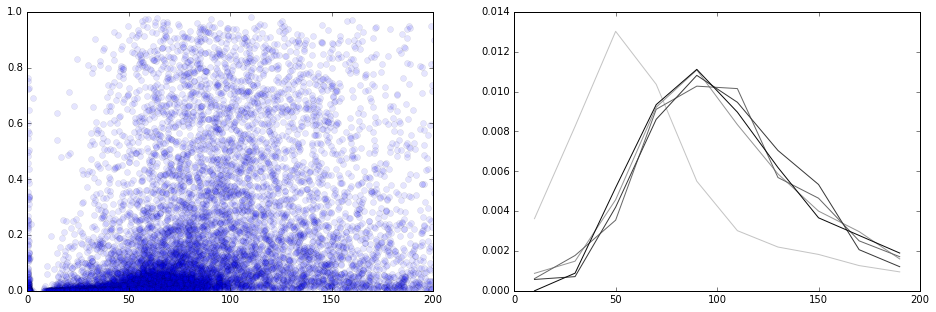

In [14]:
preds_all = bdt.predict_proba(X)[:,1]

fig, axs = plt.subplots(1,2,figsize=(16,5))

plt.subplot(1,2,1)
plt.plot(higgs_mass[y==0], preds_all[y==0], 'o', alpha=0.1)
plt.gca().set_xlim(0,200)

plt.subplot(1,2,2)
bins = np.linspace(0, 200, 11)
delta = 0.2
contents = []
bin_centers = []
for x in np.arange(0,1,delta):
    c,b,_ = plt.hist(higgs_mass[(y==0) & (preds_all > x) & (preds_all < x+delta)], 
            bins = bins, histtype='step', normed=True, color=str(0.8-(x+delta)/1.3))
    contents.append(c)
    bin_centers.append((b[:-1]+b[1:])/2.0)
plt.cla()
for i in range(len(contents)):
    plt.plot(bin_centers[i], contents[i], '-', color=str(0.95-(i+1)*delta/1.1))


In [15]:
X_data = get_bdt_input(df_data, bdt_features)
X_bkg = get_bdt_input(df_bkg, bdt_features)
X_sig = get_bdt_input(df_sig, bdt_features)
df_data["bdt_score"] = bdt.predict_proba(X_data)[:,1]
df_bkg["bdt_score"] = bdt.predict_proba(X_bkg)[:,1]
df_sig["bdt_score"] = bdt.predict_proba(X_sig)[:,1]

## Get most important features
Get the "importance score" via various metrics for each of the input features. Here they're ranked by "gain".
As exepected from intuition and above comparison plots, the relIso and di-meson dR are the most important variables.

In [16]:
# get the most important features

gains = bdt.get_booster().get_score(importance_type="gain")
covers = bdt.get_booster().get_score(importance_type="cover")
weights = bdt.get_booster().get_score(importance_type="weight")
scores = pd.DataFrame(gains.items(), columns=["feature","gain"])
scores["cover"] = scores.feature.map(lambda f:covers[f])
scores["weight"] = scores.feature.map(lambda f:weights[f])
scores = scores.sort_values('gain', ascending=False)
scores.index = range(scores.shape[0])
scores

,feature,gain,cover,weight
0,mcand_relIso,135.582152,1137.489903,61
1,mcand_dR,86.274164,752.653280,162
2,mcand_pt,65.661612,629.290540,182
3,lepton_photon_dR,56.589053,892.790259,83
4,mcand_mass,35.487999,984.389748,90
5,mcand_photon_dR,27.371696,642.266778,113
6,vhAngles_cosTheta1,22.575832,1093.905466,65
7,photon_relChHadIso,19.170831,1143.321258,23
8,vhAngles_cosThetaStar,18.515563,592.889925,26
9,lepton_pt,15.387430,359.024266,83


In [17]:
# write BDT to file
utils.BDTtoJSON("bdt_{0}.json".format(mname), bdt.get_booster(), bdt_features)
utils.JSONtoC("bdt_{0}.json".format(mname), "bdt_{0}.C".format(mname))

## Get a BDT working point
Get a BDT working point by maximizing S/sqrt(B) as a function of BDT threshold. To estimate B, use data in the mass sidebands (100,120)U(130,180). FOr now just scale by 10/70 to get the estimated B in the fitting window (120,130). Below we will use a more appropriate fit function.

Max thresh: 0.8570794
Max signif: 3.8247432192439184
nSig: 8.04885512256
nBkg: 4.428571428571429


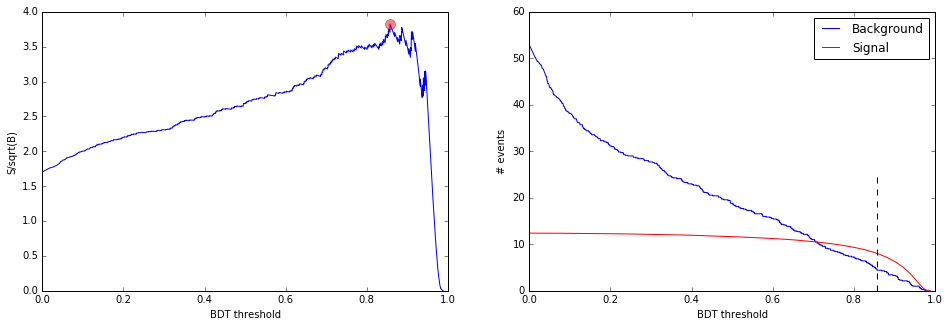

In [20]:
selection = "mcand_photon_mass > 100 & mcand_photon_mass < 180"
X_data = df_data.query(selection + " & (mcand_photon_mass < 120 | mcand_photon_mass > 130)")
X_sig = df_sig.query(selection)
preds = np.concatenate((X_data.bdt_score.values, X_sig.bdt_score.values))
issig = np.concatenate((np.zeros(X_data.shape[0]), np.ones(X_sig.shape[0])))

fpr, tpr, thresh = roc_curve(issig, preds)
nSig = X_sig.shape[0]*tpr * 0.081793152*5e-3  # using a baseline H->Xgamma BR of 5e-3
nBkg = X_data.shape[0]*fpr * 10.0/70.0
significance = nSig / np.sqrt(np.maximum(nBkg,1))

imax = np.argmax(significance)

fig, axs = plt.subplots(1,2,figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(thresh, significance, '-')
plt.xlabel("BDT threshold")
plt.ylabel("S/sqrt(B)")
plt.plot([thresh[imax]],[significance[imax]],'ro', markersize=10.0, alpha=0.5)
plt.subplot(1,2,2)
plt.plot(thresh,nBkg, 'b-', label="Background")
plt.plot(thresh,nSig, 'r-', label="Signal")
plt.plot([thresh[imax]]*2,[0,np.amax(nSig)*2],'k--')
plt.xlabel("BDT threshold")
plt.ylabel("# events")
plt.legend()

print "Max thresh:", thresh[imax]
print "Max signif:", significance[imax]
print "nSig:", nSig[imax]
print "nBkg:", nBkg[imax]

## Fit signal and background models
* Fit signal with a double crystall ball function
* Fit background from data sidebands in mass region (100,120)U(130,180).
* Test a number of different background functions: linear, quadratic, exponential, power law

In [119]:
def get_final_events(df):
    X = get_bdt_input(df, bdt_features)
    preds = bdt.predict_proba(X)[:,1]
    evts = df["mcand_photon_mass"].values
    evts = evts[preds > thresh[imax]]
    evts = evts[evts > 100]
    evts = evts[evts < 180]
    return evts

def get_poisson_error(N, alpha=0.6827):
    from scipy.stats import gamma
    err_dn = N - gamma.ppf((1-alpha)/2, N)
    err_up = gamma.isf((1-alpha)/2, N+1) - N
    if type(err_dn)==float:
        err_up = np.array([err_up])
        err_dn = np.array([err_dn])
    err_dn[np.isnan(err_dn)] = 0
    return np.column_stack((err_dn, err_up)).T

# get the histogram bin contents
bins = np.arange(100,180.1,1)

h_sig = np.histogram(get_final_events(df_sig), bins=bins)[0].astype(float)
BR = 5e-3
sig_weight = 1.380 * 1000 * 0.216 / 500000 * 137.2 * BR

h_data,_ = np.histogram(get_final_events(df_data), bins=bins)
h_blinded = np.copy(h_data)
err_blinded = get_poisson_error(h_blinded)
for i in range(20,30):
    h_blinded[i] = 0
    err_blinded[:,i] = [0,0]
    
# setup fit
utils = reload(utils)
utils.FIT_BLINDED = True
utils.FIT_BINCONTENTS = h_blinded
utils.FIT_FUNC = utils.fit_pow
fit_pow = Minuit.from_array_func(utils.binned_likelihood, (h_blinded.sum(), -2.0), error=(1.0,0.1), 
                                 name=("N","a"), errordef=0.5)
fit_pow.migrad()
fit_pow.minos()

utils.FIT_FUNC = utils.fit_exp
fit_exp = Minuit.from_array_func(utils.binned_likelihood, (h_blinded.sum(), 50.0), error=(1.0,1.0), 
                                 name=("N","a"), errordef=0.5)
fit_exp.migrad()
fit_exp.minos()

utils.FIT_FUNC = utils.fit_quad
fit_lin = Minuit.from_array_func(utils.binned_likelihood, (h_blinded.sum(), 0, 0), error=(0.5,1.0,0.1), 
                                 fix=(False,True,False), name=("N","a","b"), errordef=0.5)
fit_lin.migrad()
fit_lin.minos()

utils.FIT_FUNC = utils.fit_quad
fit_quad = Minuit.from_array_func(utils.binned_likelihood, (h_blinded.sum(), 0, 0), error=(0.5,0.0001,0.1), 
                                  fix=(False,False,False), name=("N","a","b"), errordef=0.5)
fit_quad.migrad()
fit_quad.minos()

utils.FIT_FUNC = utils.fit_crystalBall
utils.FIT_BINCONTENTS = h_sig
utils.FIT_BLINDED = False
fit_sig = Minuit.from_array_func(utils.chisquared, (np.amax(h_sig), 125.0, 2.0, 2.0, 1.0),
                                 error=(1.0, 0.1, 0.5, 0.1, 0.1), name=("N","mu","sigma","alpha","n"), errordef=1)
fit_sig.migrad()
fit_sig.minos()

print "EXPONENTIAL\n", fit_pow.get_param_states()
print "POWER\n", fit_exp.get_param_states()
print "LINEAR\n", fit_lin.get_param_states()
print "QUADRATIC\n", fit_quad.get_param_states()
print "SIGNAL\n", fit_sig.get_param_states()

EXPONENTIAL
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | N    |    36     |     7     |     -6     |     7      |         |         |       |
| 1 | a    |   -4.0    |    1.1    |    -1.1    |    1.0     |         |         |       |
------------------------------------------------------------------------------------------
POWER
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | N    |    37     |     7     |     -6     |     7      |         |         |       |
| 1 | a    |    33     |     9     |     -7     |     12     |         |

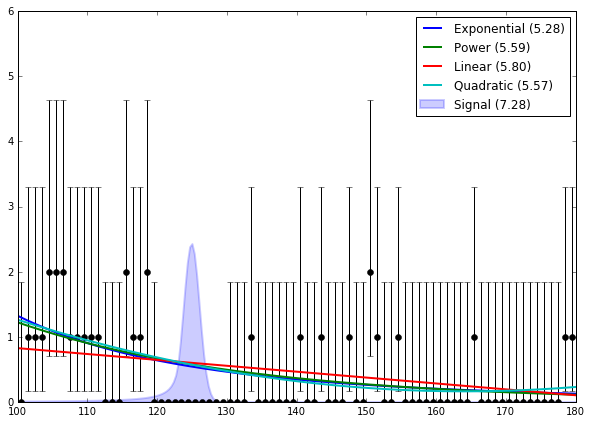

In [120]:
plt.figure(figsize=(10,7))
centers = 0.5*(bins[:-1]+bins[1:])
plt.errorbar(centers, h_blinded, yerr=err_blinded, fmt='ok')
#plt.plot(centers, h_sig, 'k-', linewidth=2)
x = np.linspace(100,180,241)
y_pow = utils.fit_pow(x, fit_pow.values.values())
y_exp = utils.fit_exp(x, fit_exp.values.values())
y_lin = utils.fit_quad(x, fit_lin.values.values())
y_quad = utils.fit_quad(x, fit_quad.values.values())
y_sig = utils.fit_crystalBall(x, fit_sig.values.values()) * sig_weight
ints = [np.trapz(y[60:90],x[60:90]) for y in [y_pow,y_exp,y_lin,y_quad,y_sig]]
plt.plot(x, y_pow, '-', linewidth=2, label="Exponential ({0:.2f})".format(ints[0]))
plt.plot(x, y_exp, '-', linewidth=2, label="Power ({0:.2f})".format(ints[1]))
plt.plot(x, y_lin, '-', linewidth=2, label="Linear ({0:.2f})".format(ints[2]))
plt.plot(x, y_quad, '-', linewidth=2, label="Quadratic ({0:.2f})".format(ints[3]))
plt.fill_between(x, y_sig, linewidth=2, color='b',alpha=0.2, label="Signal ({0:.2f})".format(ints[4]))
plt.gca().set_xlim(100,180)
plt.gca().set_ylim(0,6)
plt.legend();